# ANÁLISE DE PORTFÓLIO - PARTE 2.
# Um estudo de caso usando séries temporais com Python<br>

## Otimizacao de Portfólios pelo Método da Fronteira Eficiente, com Python
#### Rio de Janeiro, 30/08/2018
[Antonio Roberto Mendes Barberá](https://rbarbera2.wixsite.com/backlog/)

# Motivação e Inspiração.

Meu interesse pessoal em pesquisas na área de finanças acabou me conduzindo ao GitHub e ao artigo de [Ricky Kim](https://github.com/tthustla) que me inspirou a criar uma forma prática e, tanto quanto possível didática, de compartilhar os conhecimentos adquiridos ao longo de minha jornada pelo entendimento e aplicação prática da análise de séries temporais, especialmente em língua Portuguesa. 

Séries temporais compõem um campo do conhecimento tão vasto quanto árido e é, atualmente, uma das habilidades menos conhecidas pelos cientistas de dados. Há um conjunto de cursos on-line, dentre os quais destaca-se um oferecido pelo consórcio COURSERA, que é composto de cinco cursos ministrados pela [Universidade de Genebra](https://www.coursera.org/specializations/investment-management), em parceria com o UBS. Os cursos não tratam especificamente da modelagem de séries temporais, mas abordam o assunto dentro das estratégias de investimento e das teorias que as cercam. O terceiro módulo, dos cinco que compõem o curso trata, especificamente, da Moderna Teoria dos Portfólios e, em especial, do assunto que será aqui tratado mais adiante, chamado de **Método da Fronteira Eficiente para otimização de portfólios**. 

Pelo que pude verificar, não há, no entando, qualquer menção ao uso de Python nos cursos que tratam de Anaálise de Séries Temporais (Time Series Analysis), mas há o brilhante artigo que citei no início deste trabalho, que esmiúça e utiliza as principais bibliotecas Python, disponíveis para a modelagem de séries temporais. Agradeço, portanto, a Ricky Kim, por esta possibilidade, que me permitiu generalizar os conceitos e ferramentas por ele apresentadas, aplicando-as a um portfólio real, composto de ativos nacionais e originados na B3-Bovespa e, desta forma, poder compartilhar o conteúdo produzido.

**Obs**.:A descrição do critério de montagem e da escolha dos ativos componentes do portfólio é descrita na PARTE-1 deste artigo.

# Conceitos Usados.

### Portfólio.

É qualquer conjunto de ativos de risco. O risco do portfólio é uma combinação proporcional dos riscos dos ativos que o constituem.

### Portfólio Eficiente.

É o portfólio cuja combinação de ativos proporciona o melhor expectativa possível de retorno, para determinado nível de risco, em relação ao retorno de um capital "isento de risco".

### Fronteira Eficiente (ou de Eficiência).

É a linha imaginária, mas que pode ser representada graficamnte, que delimita a porção do conjunto de portfólios que oferece  expectativa máxima de retorno para determinado nível de risco, porém, não apenas os de menor risco.

<img src="Fro_Eff.PNG" align="left" /> <br>
</br>
**Obs**.: círculos coloridos de diâmetros diferentes sugerem alocações percentuais diferentes.

### Perfis de Portfólios.

Procuram definir composições que estejam adequados ao nível de propensão ao risco, manifestado pelo investidor.<br>

<img src="Perfis_Port.PNG" align="left" /> <br>

### Algumas considerações para refletirmos.

- O conceito de Fronteira Eficiente é baseado exclusivamente no passado. As correlações entre ativos componentes mudarão constantemente. O desempenho dos últimos cinquenta anos, será diferente para os próximos cinquenta? Só o tempo dirá.

- Todo ano novos dados serão agregados e o portfólio ideal tende a mudar. É preciso estar atento aos ajustes necessários. No meu caso, para portfóloios de ações, uso a inspeção na mesma periodicidade da divulgação dos resultados das açóes da carteira. Aqui no Brasil (B3 Bovespa) a periodicidade é trimestral. Nada impede das inspeções serem em periodicidade diferente, desde que haja informações suficientes.

- Há um número ilimitado de ativos que possam compor portfólios. 

- Custos incorridos, comos impostos, taxas de corretagem, custória e emolumentos não são levadas em conta neste estudo. Elas claramente impactam o desempenho final do portfolio, mas não há forma segura de envolvê-los diretamente nos modelos sem risco de distorção completa.

# Aquecendo as turbinas.

Inicialmente precisa ser disponibilizado o primeiro conjunto de bibliotecas Python que nos permitirá iniciar o trabalho. A lista de "imports" a seguir, estabelece os primeiros requisitos funcionais (requirements). Todas as bibliotecas listadas são "open-source" e podem ser obtidas por meio do gerenciador de pacotes "pip" ou "conda", se o ambiente for Anaconda 3.x ou superior:

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import os as os
# from matplotlib.pylab import rcParams
# import seaborn as sns
plt.style.use('fivethirtyeight')
# rcParams['figure.figsize'] = 20, 8
np.random.seed(777)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Lendo o arquivo que contém o portfólio. 

A obtenção e a montagem do arquivo lido a seguir, aparece descrita na PARTE-1 deste artigo no item **Anexo**. Os dados foram obtidos a partir do serviço gratuito de dados financeiros, on-line, AlphaVantage e todo o código Python necessário lá aparece documentado.

A seguir, o código Python que disponibiliza o portofólio como um Pandas Dataframe, indexado pela coluna "datetime". 

**Obs**.: tanto o path, como o nome do arquivo, referenciados a seguir, podem ser mudados de acordo com a localização física utilizada..

In [2]:
# path = "X:/Historico_Cotacoes/teste/alpha_data/"
nomeArq = 'alphacart12018.csv'
# pwd = os.getcwd() # guarda o path corrente
# os.chdir(os.path.dirname(path)) # muda para o path dos arquivos

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(nomeArq, parse_dates=["datetime"], index_col="datetime", date_parser=dateparse)

- A seguir, primeira visualizanção das características básicas do portfólio, que já nasce indexado pela data(campo datetime) que tem periodicidade diária.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66649 entries, 2000-01-05 to 2018-08-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CODNEG     66649 non-null  object 
 1   adj_close  66649 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


- definindo o intervalo temporal de observação, que vai de 01/01/2013 a 31/12/2018, com dados completos até 31/08/2018:

In [4]:
## Definindo a data de inicio das observacoes, quando todos os ativos possuem dados
start_date = "2013-01-02"
end_date = "2018-12-31"
s = data.loc[start_date:end_date] 
data = s.copy()

- em seguida, vamos preparar os dados para condensação pivotal, com as colunas passando a ser "povoadas" pelos símbolos dos ativos componentes do portfólio, todos relacionados pela data da informação de preço. Antes, precisamos efetuar o "reset" do índice:

In [5]:
df = data.reset_index()
df = df[['datetime', 'CODNEG', 'adj_close']]

- verificando a estrutura do portfólio, após reset do índice:

In [6]:
df.head()

,datetime,CODNEG,adj_close
0,2013-01-02,ABEV3,13.4001
1,2013-01-03,ABEV3,13.6377
2,2013-01-04,ABEV3,13.4129
3,2013-01-07,ABEV3,13.5676
4,2013-01-08,ABEV3,13.5516


- conferindo as colunas e sua posição relativa no dataframe:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23988 entries, 0 to 23987
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   23988 non-null  datetime64[ns]
 1   CODNEG     23988 non-null  object        
 2   adj_close  23988 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 562.3+ KB


- a seguir é criada a pivot-table de todos os ativos e valores nas datas observadas:

In [8]:
table = df.pivot_table(index = 'datetime', columns = 'CODNEG', values = 'adj_close')
table.columns.name=None

- a seguir o aspecto da pivot-table de nome "table".

In [9]:
table.head()

,ABEV3,CIEL3,EGIE3,EZTC3,GRND3,HGTX3,ITSA3,ITUB3,LREN3,MDIA3,PETR3,PSSA3,RADL3,VALE3,WEGE3
datetime,,,,,,,,,,,,,,,
2013-01-02,13.4001,9.7763,22.5061,16.1154,2.5090,32.5219,6.2276,7.4768,9.7304,21.6813,18.9448,18.3768,22.2132,34.1541,6.5403
2013-01-03,13.6377,9.8265,22.7421,16.1824,2.4602,33.1979,6.1448,7.7116,9.7486,21.6813,19.3024,18.6104,22.1187,33.5733,6.8331
2013-01-04,13.4129,9.8365,22.2837,16.2432,2.4892,33.5884,6.1840,7.6806,9.7364,22.0031,19.6890,18.6883,21.8351,33.0544,6.7518
2013-01-07,13.5676,9.8599,21.7714,15.9390,2.5655,33.5358,6.1405,7.5964,9.5705,22.2409,19.5151,18.5715,21.7406,32.4038,6.6704
2013-01-08,13.5516,9.7128,21.5692,16.0607,2.5732,32.3491,6.1405,7.5831,9.5196,22.1710,19.0028,19.0699,21.7406,32.1483,6.4031


- a partir de "table", obteremos a primeira "foto" do portfólio, com as séries de preços ajustados de seus ativos componentes, representados graficamente em conjunto:

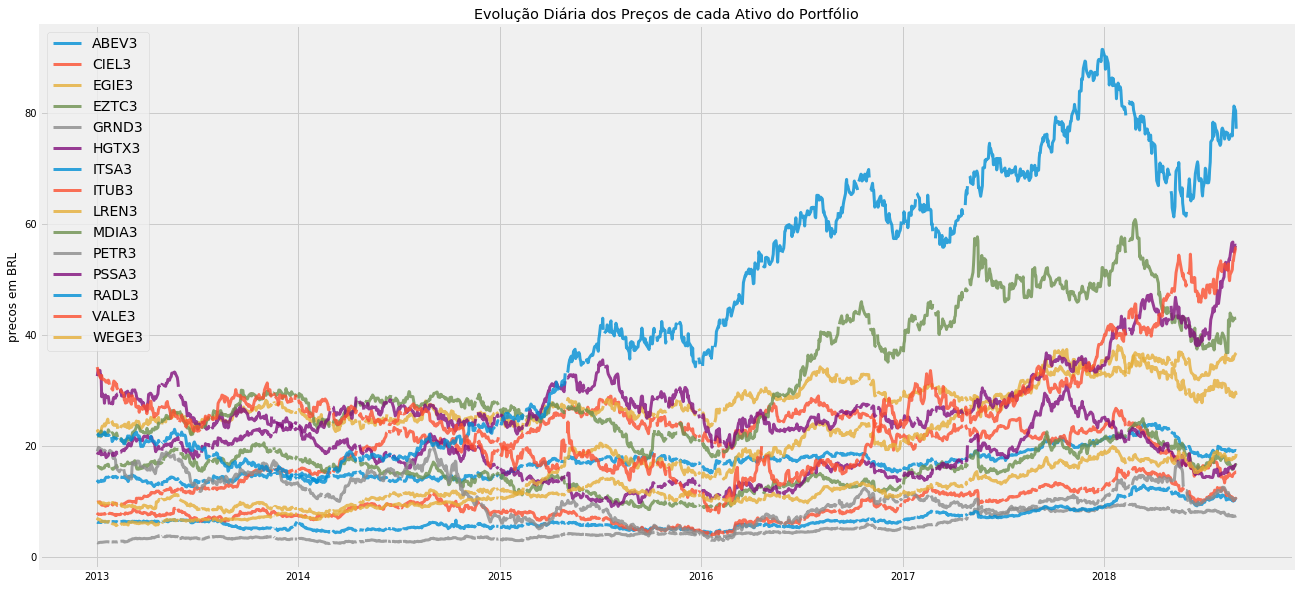

In [10]:
plt.figure(figsize=(20, 10))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8, label=c)
    
legend = plt.legend(loc='upper left', fontsize=14)
plt.setp(legend.get_texts(), color='k')   
# plt.legend(loc='upper left', fontsize=14)
plt.title('Evolução Diária dos Preços de cada Ativo do Portfólio')
plt.ylabel('precos em BRL');

Parece que os preços, de uma maneira geral, apresentam tendência de alta, ou permanecem estacionários no período, o que era de se esperar (mesmo no mercado de alta volatilidade como é o brasileiro) pelo fato do portfólio ser composto por ações de empresas com bons fundamentos. 

## Trabalhando com a variação dos preços.

Outra maneira de observar ativos seria a de traçarmos os retornos diários (variação percentual em comparação com o dia anterior). Ao traçar retornos diários, ao invés dos preços reais, podemos enxergar mais claramente a volatilidade dos preços dos ativos componentes do portfólio. Isto pode ser obtido usando-se o método Python pct_change (variação percentual), como é mostrado a seguir:

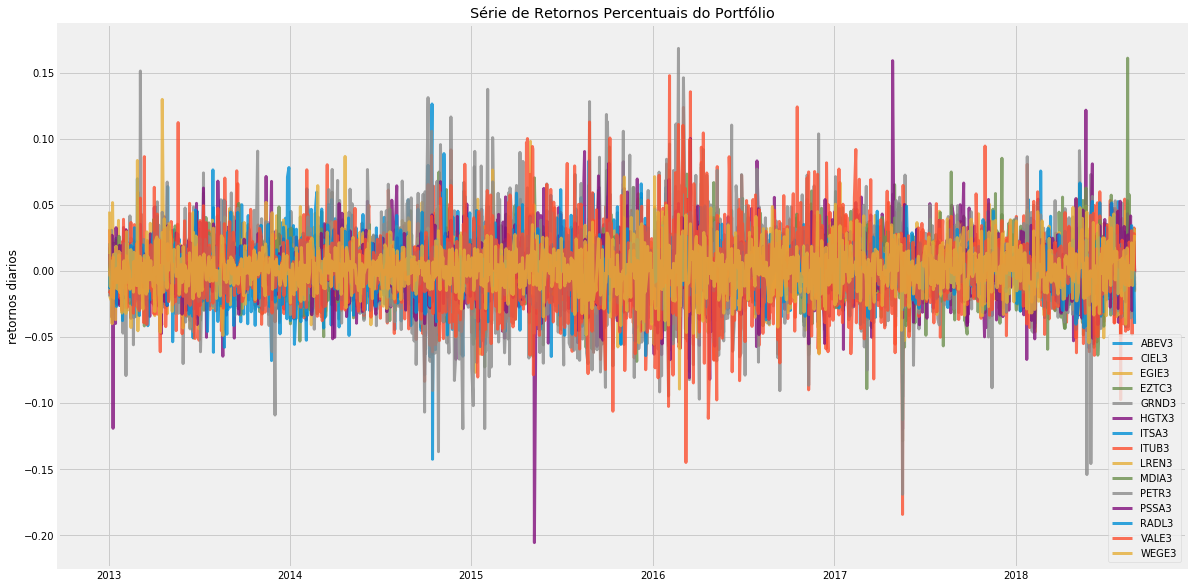

In [11]:
returns = table.pct_change() ## retornos

plt.figure(figsize=(18, 10))
plt.setp(legend.get_texts(), color='k');

for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
    
legend = plt.legend(loc='best', fontsize=10)

#plt.legend(loc='lower right', fontsize=10)
plt.title('Série de Retornos Percentuais do Portfólio')
plt.ylabel('retornos diarios')
plt.show();

Todos os ativos apresentam alta volatilidade de preços no período. Os topos e fundos se tornam mais agudos, em alguns casos. Para melhor visualização, o gráfico individualizado seria mais adequado. Mas aqui, nosso foco é o portfólio. 

## Geração Randômica de Portfólios.

Temos 15 ações no portfólio. Uma decisão corriqueira é a de como alocar dinheiro novo e distribuí-lo por cada uma das ações nele contidas. Se nosso orçamento total fosse 1, poderíamos definir pesos para cada ativo componente, de modo que a soma deles fosse igual a 1. E o valor de cada peso corresponderia à parte do orçamento que estaríamos alocando especificamente a cada ativo. Por exemplo, se o peso for 0.5 para ABEV3, significa que estaríamos alocando 50% de nosso orçamento para compras de açoes de ABEV3.

Vamos, então, definir algumas funções para simularem pesos aleatórios para cada ativo do portfólio e, em seguida, calcular os **retornos globais** e a **volatilidade anualizada**, ambos anualizados, para todo o portfólio:

A função **portfolio_annualised_performance** calculará os retornos e a volatilidade e, para tornar o cálculo anualizado, será considerado **252** como o número de dias de negociação, em um ano. A função **random_portfolios** gerará carteiras com pesos aleatórios atribuídos a cada ação e, se fornecido o argumento **num_portfolios**, será gerado igual número de carteiras aleatórias.

In [12]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    dim_res = len(table.columns) ## cuidado para não renomear table
    results = np.zeros((dim_res,num_portfolios)) ## 
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(dim_res)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, \
                                              mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

O código acima, duas coisas chamam a atenção:

**1** - a primeira, é o cálculo da **volatilidade da carteira** dada pela função ** portfolio_annualised_performance**. Se procurarmos pelo trecho **portfolio standard deviation formula**, encontraremos a fórmula a seguir:

${\sigma}_{portfolio}$ = $\sqrt{ {\omega_1}^2{\sigma_1}^2 + {\omega_2}^2{\sigma_2}^2 + 2\omega_1\omega_2Co\nu_{1,2} }$

Obs.: a fórmula acima pode ser simplificada, em termos de economia de esforço computacional, se for usada em sua [notação matricial](ver https://goo.gl/tAst18de).

De maneira análoga, como foi definido para o cálculo do retorno anualizado, foram considerados 252 dias úteis (de negociação anuais), para calcularmos o desvio padrão anualizado da carteira.

**2** - a segunda, é o uso do índice de Sharpe. Para entender o índice de Sharpe é preciso incorporar o conceito de **retorno com risco ajustado (risk-adjusted return). O retorno com risco ajustado** é um refinamento do retorno do investimento, medindo-se o quanto de risco está envolvido no retorno produzido, o que é geralmente expresso como um número, ou uma relação. O índice de Sharpe é uma destas relações.

O **Sharpe ratio**, como é conhecido, descreve o quanto de **excesso de retorno** está sendo recebido, para a **volatilidade extra suportada**, quando o investidor se mantém "comprado" num ativo mais arriscado. O índice de Sharpe pode ser expresso pela seguinte fórmula:

$Sharpe = \frac{\bar{r_p}-r_f}{\sigma_p}$

onde:<br>
$\bar{r_p}$ = retorno médio esperado do portfólio <br>
$r_f$ = retorno médio de um ativo sem risco (título do tesouro amearicano, ou brasileiro, por ex.)<br>
$\sigma_p$ = desvio padrão da carteira (portfólio)

Há algumas restrições ao uso do índice de Sharpe, uma vez que ele utiliza o desvio padrão dos retornos, como denominador. Isto pressupõe que os retornos obedeçam a uma distribuição normal (gaussiana). No entanto, no mundo real, os retornos dos ativos financeiros tendem a apresentar desvios que raramente se aproximam da normal, o que pode levar ao uso inadequado do índice de Sharpe e a interpretações errôneas. Por esta razão, há métodos alternativos que ajustam, ou transformam o índice original de Sharpe, mas que fogem ao escopo deste trabalho introdutório, por serem técnicas mais sofisticadas.

Vamos, então, obter os valores dos argumentos necessários para o uso das nossas funções. Os retornos diários podem ser facilmente obtidos, aplicando a função **pct_change()**, ao conjunto de dados de preços. Os **retornos diários médios** e a **matriz de covariância dos retornos** são necessários para calcular os retornos e a volatilidade da carteira. Vamos obtê-los e gerar **25.000** portfólios aleatórios. 

Finalmente, a **taxa livre de risco** foi retirada do Tesouro Direto - títulos pós fixados com atualização pelo IPCA - cuja taxa de juros ofertada era de 3,45% aa, no início de 2018. A razão por trás desta escolha está no fato de que os dados de preços históricos abrangem do período dos últimos 5 anos - de 2013 a 2018 - e foi assumida, como momento de análise, o início de 2018, uma vez que fornecia a taxa mais atualizada do Tesouro Direto.

In [13]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0413

A função definida a seguir, em primeiro lugar, gera um porfólio (carteira) aleatório e obtém os resultados (retornos, volatilidade e índice de Sharpe do portfólio) e os pesos usados para a obtenção dos resultados correspondentes. 

Em segundo lugar, após identificar o portfólio que possui índices de Sharpe mais elevados, ela exibe este portfólio de **índice de Sharpe máximo, em vermelho**. Realiza, ainda, tratamento análogo para a identificação do portfólio de **volatilidade mínima e o exibe como um asterisco (estrela) verde**, na grade gráfica. 

Todos os portfólios gerados aleatoriamente são, também, plotados e associados a um mapa de cores, que variam de acordo com o índice de Sharpe. A cor **Mais azul**, significa **maior o índice de Sharpe**. E para estes dois portfólios ótimos - **com máximo índice de Sharpe** e com **mínima volatilidade** - ela mostrará como se daria a alocação percentual do orçamento, dentro do portfólio.

In [14]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Alocacao da Carteira pelo Indice de Sharpe Maximo\n")
    print ("Retorno Anualizado:", round(rp,2))
    print ("Volatilidade Anualizada:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Alocacao da Carteira pela Volatilidade Minima\n")
    print ("Retorno Anualizado:", round(rp_min,2))
    print ("Volatilidade Anualizada:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)

    plt.figure(figsize=(12, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Indice de Sharpe Maximo')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Volatilidade Minima')
    
    plt.title('Simulacao de Portfolio Optimizado com base na Fronteira Eficiente')
    plt.xlabel('volatilidade anualizada')
    plt.ylabel('retornos anualizados')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Alocacao da Carteira pelo Indice de Sharpe Maximo

Retorno Anualizado: 0.19
Volatilidade Anualizada: 0.18


            ABEV3  CIEL3  EGIE3  EZTC3  GRND3  HGTX3  ITSA3  ITUB3  LREN3  \
allocation   0.65   0.89    4.9   2.61  20.61   4.31   1.82   4.76   8.62   

            MDIA3  PETR3  PSSA3  RADL3  VALE3  WEGE3  
allocation   8.86   1.72   0.95  20.75    0.5  18.08  
--------------------------------------------------------------------------------
Alocacao da Carteira pela Volatilidade Minima

Retorno Anualizado: 0.16
Volatilidade Anualizada: 0.16


            ABEV3  CIEL3  EGIE3  EZTC3  GRND3  HGTX3  ITSA3  ITUB3  LREN3  \
allocation   11.1   3.03  11.04   6.89   6.32   5.43   3.68   0.76   6.44   

            MDIA3  PETR3  PSSA3  RADL3  VALE3  WEGE3  
allocation  11.04   0.44  11.04  11.86   0.65  10.28  


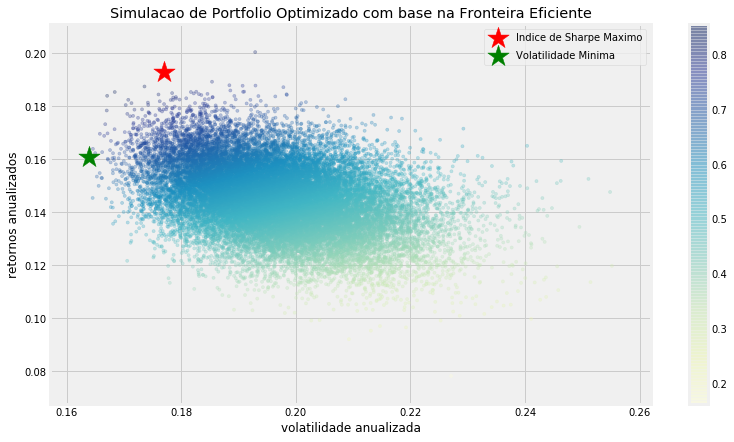

In [15]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Para um portfólio de risco mínimo, podemos ver que mais da metade do orçamento é alocado em ---. Se voltarmos e olharmos o gráfico de retorno diário, no início, iremos lembrar que ---- é a ação menos volátil, dentre as quatro analisadas. Portanto, sob esta ótica, **faz todo o sentido alocar uma grande porcentagem do orçamento em ---**, uma vez que se trata do  **portfólio de risco mínimo**.

Para um investidor disposto a assumir um risco maior - com chance de retorno mais alto - a alocação que nos dá o **melhor retorno ajustado ao risco** é aquela que apresenta **índice de Sharpe máximo**. Neste cenário, estaríamos alocando uma parcela significativa de nosso orçamento de investimentos, nos ativos --- e ---, que são as ações mais voláteis, segundo o gráfico anterior de retornos diários. E as ações ---, que representavam mais de ---% do portfólio de risco mínimo, receberia alocação inferior a 1%, neste perfil de portfólio.

## A Fronteira Eficiente

A partir do gráfico dos portfólios randomicamente simulados, destaca-se uma linha em forma de arco, no topo de pontos azuis agrupados. Esta linha é chamada de **fronteira eficiente**. Trata-se da região em que os pontos desta fronteira representam  o menor risco, para um determinado retorno desejado. Todos os outros pontos à direita desta linha, representam investimentos com risco maior, mas com os mesmos retornos. Se os retornos esperados são os mesmos, qual seria a vantagem de tomarmos risco extra?

A maneira como encontramos os dois tipos de portfólio ideal, no gráfico acima, foi a partir da simulação de múltiplas e possíveis escolhas tomadas aleatoriamente e selecionando as melhores (tanto sob a ótica do risco mínimo, quanto a do retorno máximo ajustado ao risco). Esta abordagem pode ser implementada a partir do uso da função optimize, da biblioteca Scipy.

Usuários avançados do Excel, normalmente usam a função "solver". A função de otimização da Scipy realiza tarefa semelhante, quando se sabe o que deve ser otimizado e quais são as respectivas restrições e limites.

As funções, a seguir, têm como finalidade obter a alocação do **portfólio com índice máximo de Sharpe**. Na função de otimização do Scipy, não há o processo "maximizar", por isto, como toda função objetivo, seria necessário passar algo a ser minimizado. Por esta razão, estará sendo calculado o índice de Sharpe negativo, ou “neg_sharpe_ratio”, que admite o uso desta função como função objetivo, em que se procurará minimizar o índice de Sharpe negativo. 

Na função “max_sharpe_ratio”, em primeiro lugar são definidos os argumentos (dentre eles não devem estar incluídas as variáveis que serão passadas durante as tentativas do processo de otimização, neste caso, os “pesos”). Em princípio, a construção das restrições é meio complicada e pouco intuitiva, devido à forma como o processo foi estruturado de forma muito "pythonizada". É usado 'dicionário' (Python dic={}) que utiliza uma função lambda.

In [16]:
constraints = ({'type': 'eq', 'fun': lambda x:np.sum(x) -1})

A expressão "constraints =" (descrita acima), que aparece no interior da função, a seguir, estabelece que a soma de 'x' deve ser igual a 1. A construção via função lambda já e naturalmente esquisita e o "1" parece ter passado do lado direito do sinal de igual, para o lado esquerdo (pela troca de sinal), como em 'np.sum (x) == 1' tornando-se 'np.sum (x) -1'. Esta construção estranha significa, simplesmente, que a soma de todos os pesos deve ser igual a 1, de modo que não seja possível alocar mais de 100% do orçamento no total, para composição do portfólio.

A variável "bounds" estabelece outro limite para atribuição de pesos aleatórios, dizendo que qualquer peso deve estar incluído no intervalo entre 0 e 1. Você não pode atribuir valor negativo e nem valores maiores do que 100% do orçamento, a uma determinada ação.

In [17]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets * [1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Também poderíamos definir uma função de otimização para calcular o **portfólio de volatilidade mínima**. Desta vez, realmente estaríamos minimizando a função objetivo. Seria minimizada a volatilidade, por meio de tentativas de uso com pesos diferentes. Os "constraints" e "bounds" seriam os mesmos da função acima. Então vejamos:

In [18]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Como já foi mencionado anteriormente, podemos, também, traçar a "fronteira eficiente", que é a linha que mostra onde procurar os retornos eficientes, conforme a propensão do investidor ao risco. A seguir, são apresentadas outras funções para cálculo e visualização da fronteira eficiente. 

A primeira função - **efficient_return** - calcula alocação do **portfólio mais eficiente**, para um determinado **objetivo alvo** de retorno, para a carteira.

A segunda função - **efficient_frontier** - fornece um **intervalo de alvos (targets)** possíveis para o retorno da carteira, e calcula um **portfólio eficiente para cada nível de retorno** apresentado.

In [19]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Vamos plotar as opções de portfólio - com o **máximo índice de Sharpe** e **volatilidade mínima** - além de todos os portfólios gerados aleatoriamente. Mas desta vez, não estaremos escolhendo os portfólios ótimos gerados aleatoriamente. Na realidade, estaremos calculando e usando a função "minimize" do Scipy. E a função abaixo irá, também, traçar a linha de fronteira eficiente.

In [24]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print ("-"*80)
    print ("Alocacao da Carteira pelo Indice de Sharpe Maximo\n")
    print ("Retorno Anualizado:", round(rp,2))
    print ("Volatilidade Anualizada:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Alocacao da Carteira pela Volatilidade Minima\n")
    print ("Retorno Anualizado:", round(rp_min,2))
    print ("Volatilidade Anualizada:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
   
    plt.figure(figsize=(12, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    target = np.linspace(rp_min, 0.28, 50)
    
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Otimização do Portfolio pelo Método da Fronteira Eficiente (Efficient Frontier)')
    plt.xlabel('volatilidade anualizada')
    plt.ylabel('retorno anualizado')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Alocacao da Carteira pelo Indice de Sharpe Maximo

Retorno Anualizado: 0.23
Volatilidade Anualizada: 0.18


            ABEV3  CIEL3  EGIE3  EZTC3  GRND3  HGTX3  ITSA3  ITUB3  LREN3  \
allocation    0.0    0.0    0.0    0.0  23.18    0.0    0.0    0.0   6.31   

            MDIA3  PETR3  PSSA3  RADL3  VALE3  WEGE3  
allocation   2.51    0.0   18.7  27.83   2.57   18.9  
--------------------------------------------------------------------------------
Alocacao da Carteira pela Volatilidade Minima

Retorno Anualizado: 0.16
Volatilidade Anualizada: 0.15


            ABEV3  CIEL3  EGIE3  EZTC3  GRND3  HGTX3  ITSA3  ITUB3  LREN3  \
allocation  25.37   4.47  16.54    0.0  12.32   0.82    0.0    0.0    0.0   

            MDIA3  PETR3  PSSA3  RADL3  VALE3  WEGE3  
allocation  10.45    0.0   7.27  10.23   0.85  11.67  


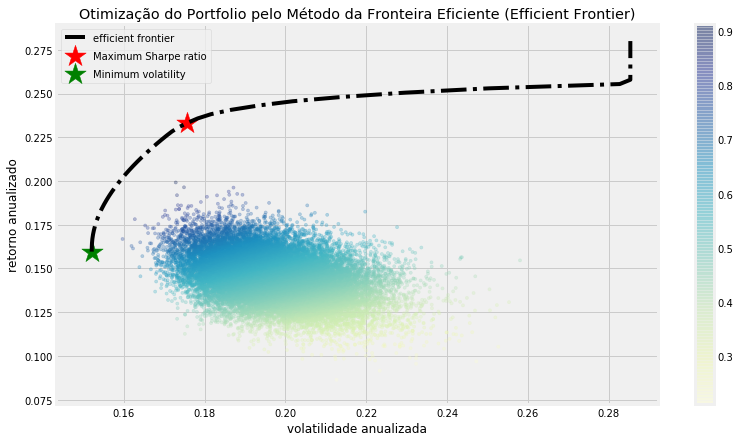

In [25]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Foram obtidos quase os mesmos resultados da simulação onde foram eleitos os melhores portfólios gerados aleatoriamente. A pequena diferença é devida ao uso da **função "optimize" da biblioteca SciPy**, que **não alocou orçamento para algumas das ações, no portfólio de índice de Sharpe máximo**. Há, ainda, umas poucas diferenças nas casas decimais.

Ao invés de plotar os portfólios gerados aleatoriamente, poderíamos **plotar cada ação individual** no gráfico, com os valores correspondentes do **retorno anual** e do **risco anual** de cada ativo componente. Desta forma, poderíamos observar o quanto a diversificação estaria diminuindo o risco do investidor, otimizando a alocação.

In [26]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T  

    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252  

    print ("-"*80)
    print ("Alocacao da Carteira pelo Indice de Sharpe Maximo\n")
    print ("Retorno Anualizado:", round(rp,2))
    print ("Volatilidade Anualizada (risco):", round(sdp,2))
    print ("\n")
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Alocacao da Carteira pela Volatilidade Minima\n")
    print ("Retorno Anualizado:", round(rp_min,2))
    print ("Volatilidade Anualizada (risco):", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Retornos e Volatilidade das Açoes Individualmente Referenciadas\n")
    
    for i, txt in enumerate(table.columns):
        print (txt,":","retorno anualizado",round(an_rt[i],2),", volatilidade anualizada (risco):",round(an_vol[i],2))
    print ("-"*80)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    
    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Indice de Sharpe Maximo')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Volatilidade Minima (risco)')

    target = np.linspace(rp_min, 0.30, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Otimizacao de Carteira com Acoes Individualmente Referenciadas')
    ax.set_xlabel('volatilidade anualizada (risco)')
    ax.set_ylabel('retorno anualizado')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Alocacao da Carteira pelo Indice de Sharpe Maximo

Retorno Anualizado: 0.23
Volatilidade Anualizada (risco): 0.18




            ABEV3  CIEL3  EGIE3  EZTC3  GRND3  HGTX3  ITSA3  ITUB3  LREN3  \
allocation    0.0    0.0    0.0    0.0  23.18    0.0    0.0    0.0   6.31   

            MDIA3  PETR3  PSSA3  RADL3  VALE3  WEGE3  
allocation   2.51    0.0   18.7  27.83   2.57   18.9  
--------------------------------------------------------------------------------
Alocacao da Carteira pela Volatilidade Minima

Retorno Anualizado: 0.16
Volatilidade Anualizada (risco): 0.15


            ABEV3  CIEL3  EGIE3  EZTC3  GRND3  HGTX3  ITSA3  ITUB3  LREN3  \
allocation  25.37   4.47  16.54    0.0  12.32   0.82    0.0    0.0    0.0   

            MDIA3  PETR3  PSSA3  RADL3  VALE3  WEGE3  
allocation  10.45    0.0   7.27  10.23   0.85  11.67  
------------------------------------------------------------------------------

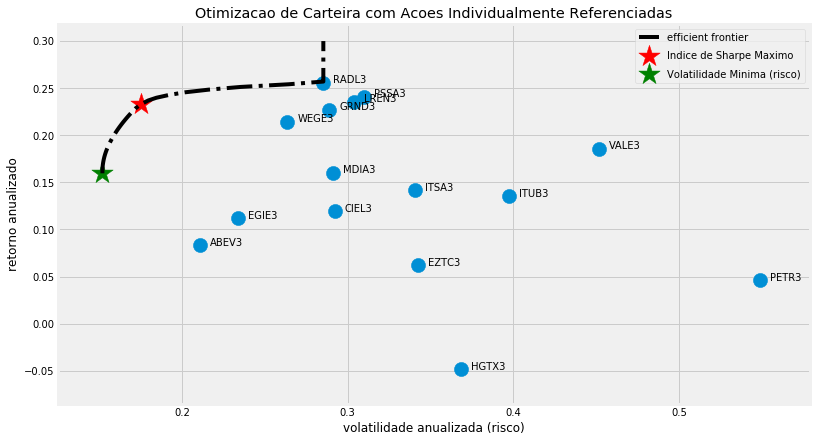

In [27]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

O gráfico acima mostra que a ação de menor risco é ABEV3, com em torno de 21%(0.21) a.a. Mas com a otimização do portfólio, podemos alcançar um risco ainda menor e igual a 15% (0.15) e ainda obter um retorno maior, de 17% (0.17) -  a estrela verde - desde que  usemos a alocação com 25.37% de ABEV3,  4.48% de CIEL3, 16.53% de EGIE3, 12.32% de GRND3, 0.81% de HGTX3, 10.45% de MDIA3, 7.27% de PSSA3, 10.23% de RADL3, 0.85% de VALE3, 11.77 de RADL3 e 0.00% de RZTC3, ITSA3, ITUB3, LREN3 e PETR3.

E, se houver disposição para assumir um pouco mais de risco (em torno do nível de risco de 18% - 0.18), podemos obter um retorno anualizado de 24% (0.24), mas com alocação mais concentrada, em 23.07% de GRND3, 6.2% de LREN3, 3.07% de MDIA3,   18.5% de PSSA3, 27.47% de RADL3, 2.69% de VALE3 e 19.00% de WEGE3. Não haveria alocações em ABEV3, CIEL3, EGIE3, EZTC3, HGTX3, ITSA3, ITUB3 e PETR3.

# Conclusão

Considerando a vastidão que é o campo das finanças, há uma infinidade de aplicações para o Método da Fronteira Eficiente. 
Markowitz, quando a enunciou, estabeleceu um grande diferencial ao apresentar a Moderna Teoria dos Portfólios. Ela demosntra que o risco de um portfólio (ou carteira de ações) não é dado simplesmente pela média do risco dos ativos individuais, pois é preciso considerar a correlação existente entre eles, no tempo. 

Sendo assim, pode-se dizer que a “palavra-chave” que permeia a teoria de Markowitz é o conceito de **diversificação**, com o intuito de reduzir risco. Markowitz desnuda, na prática, a máxima de que "não se deve colocar todos os ovos na mesma cesta".
A Teoria Moderna do Portfólio valeu o Nobel de Economia a Markowitz, em 1990.

Espero que o compartilhamento do conteúdo aqui exposto estimule alunos e colegas a aplicarem a teoria e os recursos do Python aqui descritos, no sentido de mudarmos o atual estado de coisas em nosso país e, desta forma, sensibilzar as empresas de que é possível usarmos o estado da arte da ciência dos dados, para melhorarmos a qualidade das decisões empresariais.

Aprendi muito com construção desta simulação que, na realidade, retrata um caso real de carteira de ações da B3 Bovespa. Espero que aproveitem.

Fico à disposição,


**Antonio Roberto Mendes Barberá**

**(+55)21992992949**

Leblon, Rio de Janeiro - Brasil